In [1]:
import sys

In [2]:
import numpy as np
import pandas as pd
import tweepy
import matplotlib.pyplot as plt
import pymongo
import ipywidgets as wgt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import re
from datetime import datetime

%matplotlib inline

In [3]:
api_key = "pCRLPdf2lkjpRX9Uczpt2gVBb" 
api_secret = "G1Wv7sTLMYF3cr5LbL8S9uj2g2LFrdWp8X8t7Ft3sIpW0kbqgD" 
access_token = "100875722-7m5vhOzpw2LYrB7P8ISnTqtGYMMvVTqwx3X4EyJY" 
access_token_secret = "uPEymGiszhiJEVWD4Alo1pzMUJx1ymo3Fd4HWyRPRBN3r" 

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)
col = pymongo.MongoClient()["DataWranglingDay1"]["Kolkata Knight Riders"]
col.count()

<ipython-input-3-b2138e576d57>:11: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  col.count()


2854

In [4]:
class MyStreamListener(tweepy.StreamListener):
    
    counter = 0
    
    def __init__(self, max_tweets=3000, *args, **kwargs):
        self.max_tweets = max_tweets
        self.counter = 0
        super().__init__(*args, **kwargs)
    
    def on_connect(self):
        self.counter = 0
        self.start_time = datetime.now()
    
    def on_status(self, status):
        
        self.counter += 1
        
        
        col.insert_one(status._json)
        
        
        if self.counter % 1 == 0:
            value = int(100.00 * self.counter / self.max_tweets)
            mining_time = datetime.now() - self.start_time
            progress_bar.value = value
            html_value = """<span class="label label-primary">Tweets/Sec: %.1f</span>""" % (self.counter / max([1,mining_time.seconds]))
            html_value += """ <span class="label label-success">Progress: %.1f%%</span>""" % (self.counter / self.max_tweets * 100.0)
            html_value += """ <span class="label label-info">ETA: %.1f Sec</span>""" % ((self.max_tweets - self.counter) / (self.counter / max([1,mining_time.seconds])))
            wgt_status.value = html_value
           
            if self.counter >= self.max_tweets:
                myStream.disconnect()
                print("Finished")
                print("Total Mining Time: %s" % (mining_time))
                print("Tweets/Sec: %.1f" % (self.max_tweets / mining_time.seconds))
                progress_bar.value = 0
                
    
myStreamListener = MyStreamListener(max_tweets=5000)
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
keywords = ["Kolkata Knight Riders",""
           ]


progress_bar = wgt.IntProgress(value=0)
display(progress_bar)
wgt_status = wgt.HTML(value="""<span class="label label-primary">Tweets/Sec: 0.0</span>""")
display(wgt_status)


for error_counter in range(20):
    try:
        myStream.filter(track=keywords)
        print("Tweets collected: %s" % myStream.listener.counter)
        print("Total tweets in collection: %s" % col.count())
        break
    except:
        print("ERROR# %s" % (error_counter + 1))

IntProgress(value=0)

HTML(value='<span class="label label-primary">Tweets/Sec: 0.0</span>')

Tweets collected: 0
Total tweets in collection: 2854


<ipython-input-4-dd7ac3c5e0ec>:55: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  print("Total tweets in collection: %s" % col.count())


In [5]:
col.find_one()

{'_id': ObjectId('5f9a865fe3e373b907d31dc8'),
 'created_at': 'Thu Oct 29 09:07:36 +0000 2020',
 'id': 1321740457899032576,
 'id_str': '1321740457899032576',
 'text': '@MyGate_com Team 👉 Kolkata knight riders\nBatsman 👉 Shubhman Gill\nBowler 👉 Pat Cummins\nAll Rounder 👉 Sam Curran… https://t.co/bKBVUp8odZ',
 'display_text_range': [12, 140],
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'truncated': True,
 'in_reply_to_status_id': 1321655604662792194,
 'in_reply_to_status_id_str': '1321655604662792194',
 'in_reply_to_user_id': 732898998491570177,
 'in_reply_to_user_id_str': '732898998491570177',
 'in_reply_to_screen_name': 'MyGate_com',
 'user': {'id': 1297949979999236096,
  'id_str': '1297949979999236096',
  'name': 'Akhila_akki06',
  'screen_name': 'Akhilaa16938072',
  'location': 'Telangana, India',
  'url': None,
  'description': 'born to win every thing I desire😎',
  'translator_type': 'none',
  'protected': False,
  'verified': 

In [6]:
dataset = [{"created_at": item["created_at"],
            "text": item["text"],
            "user": "@%s" % item["user"]["screen_name"],
            "source": item["source"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset = pd.DataFrame(dataset)

dataset

,created_at,text,user,source,lang
0,Thu Oct 29 09:07:36 +0000 2020,@MyGate_com Team 👉 Kolkata knight riders\nBats...,@Akhilaa16938072,"<a href=""http://twitter.com/download/android"" ...",en
1,Thu Oct 29 09:08:07 +0000 2020,Matchday is here!\n\nKolkata Knight Riders wil...,@tsrkhyderabad,"<a href=""http://twitter.com/download/android"" ...",en
2,Thu Oct 29 09:11:42 +0000 2020,आईपीएल 2020 (IPL 2020) में आज 49वां मुकाबला चे...,@hnlhindi,"<a href=""https://www.fs-poster.com"" rel=""nofol...",hi
3,Thu Oct 29 09:11:47 +0000 2020,@ByloApp Kolkata Knight Riders\n#iplcontest #g...,@deora_gunjan,"<a href=""http://twitter.com/download/android"" ...",en
4,Thu Oct 29 09:13:02 +0000 2020,RT @tsrkhyderabad: Matchday is here!\n\nKolkat...,@teamsrkmumbaifc,"<a href=""http://twitter.com/download/android"" ...",en
...,...,...,...,...,...
2849,Sun Nov 01 18:52:48 +0000 2020,"IPL 2020, KKR vs RR: Eoin Morgan, Pat Cummins ...",@Prakash_9955,"<a href=""https://www.fs-poster.com"" rel=""nofol...",en
2850,Sun Nov 01 18:53:25 +0000 2020,"IPL 2020, KKR vs RR: Eoin Morgan, Pat Cummins ...",@OneNewsCentre1,"<a href=""http://publicize.wp.com/"" rel=""nofoll...",en
2851,Sun Nov 01 18:53:25 +0000 2020,"IPL 2020, KKR vs RR: Eoin Morgan, Pat Cummins ...",@OneNewsCentre1,"<a href=""http://publicize.wp.com/"" rel=""nofoll...",en
2852,Sun Nov 01 18:53:44 +0000 2020,And it's over in Dubai. A clinical show from t...,@mykhelcom,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en


In [7]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(dataset.text)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,https,2352
1,co,2297
2,kolkata,1570
3,knight,1512
4,riders,1481
5,ipl2020,977
6,ipl,950
7,vs,921
8,match,905
9,rt,887


<ipython-input-8-a8481ec67a37>:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dataset.source_name = dataset.source.apply(get_source_name)


dlvr.it                 20
FS Poster               22
Tweet Good              29
Twitter for iPhone      68
CricketKhabarLive      121
CricketNDTVLive        128
TweetDeck              267
WordPress.com          483
Twitter Web App        662
Twitter for Android    895
Name: source, dtype: int64

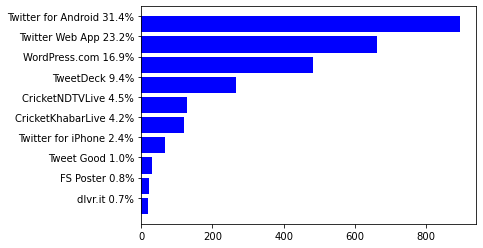

In [8]:
def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""
dataset.source_name = dataset.source.apply(get_source_name)

source_counts = dataset.source_name.value_counts().sort_values()[-10:]

bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="blue", linewidth=0)

y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(dataset)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)

source_counts

tl       15
in       17
ml       17
kn       20
bn       25
et       50
mr       75
und     104
hi      315
en     2150
Name: lang, dtype: int64

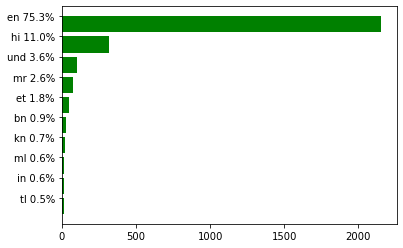

In [9]:
lang_counts = dataset.lang.value_counts().sort_values()[-10:]
bottom = [index for index, item in enumerate(lang_counts.index)]
plt.barh(bottom, width=lang_counts, color="green", linewidth=0)
y_labels = ["%s %.1f%%" % (item, 100.0*lang_counts[item]/len(dataset)) for index,item in enumerate(lang_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)
lang_counts

In [10]:
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from  textblob import TextBlob

In [11]:
dataset1 = [{"id": item["id"],
            "text": item["text"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset1 = pd.DataFrame(dataset1)

is_dataset1=dataset1.lang=="en"
dataset1=dataset1[is_dataset1]
dataset1

,id,text,lang
0,1321740457899032576,@MyGate_com Team 👉 Kolkata knight riders\nBats...,en
1,1321740587641438208,Matchday is here!\n\nKolkata Knight Riders wil...,en
3,1321741511831138306,@ByloApp Kolkata Knight Riders\n#iplcontest #g...,en
4,1321741825028153344,RT @tsrkhyderabad: Matchday is here!\n\nKolkat...,en
5,1321741825028153344,RT @tsrkhyderabad: Matchday is here!\n\nKolkat...,en
...,...,...,...
2849,1322974889846996995,"IPL 2020, KKR vs RR: Eoin Morgan, Pat Cummins ...",en
2850,1322975048542638085,"IPL 2020, KKR vs RR: Eoin Morgan, Pat Cummins ...",en
2851,1322975048542638085,"IPL 2020, KKR vs RR: Eoin Morgan, Pat Cummins ...",en
2852,1322975126623645697,And it's over in Dubai. A clinical show from t...,en


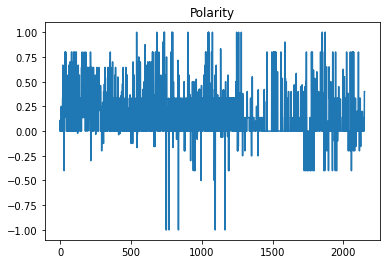

In [12]:
tweettext=dataset1['text']
wordlist=pd.DataFrame();

polarity=[]
subj=[]

for t in tweettext:
    tx= TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)

poltweet= pd.DataFrame({'polarity':polarity,'subjectivity':subj})
poltweet.polarity.plot(title='Polarity')
plt.show()

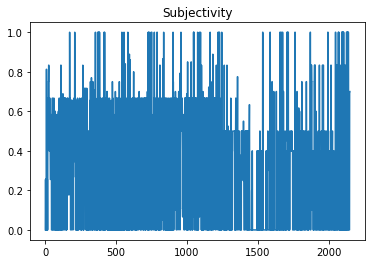

In [13]:
poltweet.subjectivity.plot(title='Subjectivity')
plt.show()

In [14]:
import statistics
statistics.mean(poltweet.polarity)

0.169976203563878

In [15]:
import statistics
statistics.mean(poltweet.subjectivity)

0.3512015810546043

In [16]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [17]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
top_N = 100


a = dataset1['text'].str.lower().str.cat(sep=' ')


b = re.sub('[^A-Za-z]+', ' ', a)
nltk.download('stopwords')
nltk.download('punkt')
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)
word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


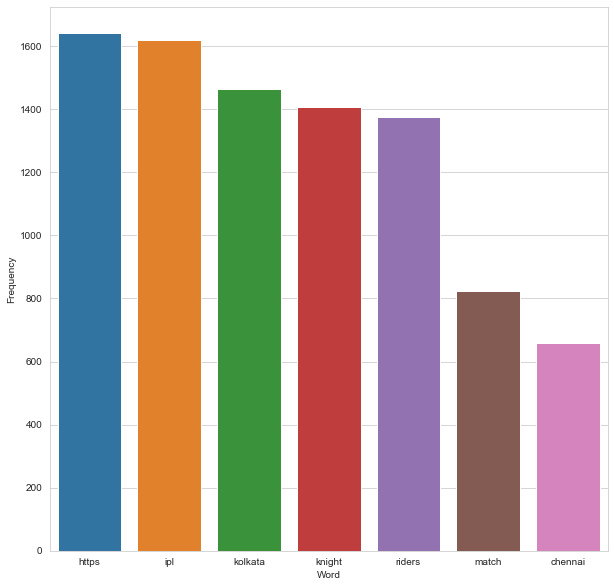

In [18]:
import seaborn as sns
 
without_single_chr = [word for word in filtered_sentence if len(word) > 2]


cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        


word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

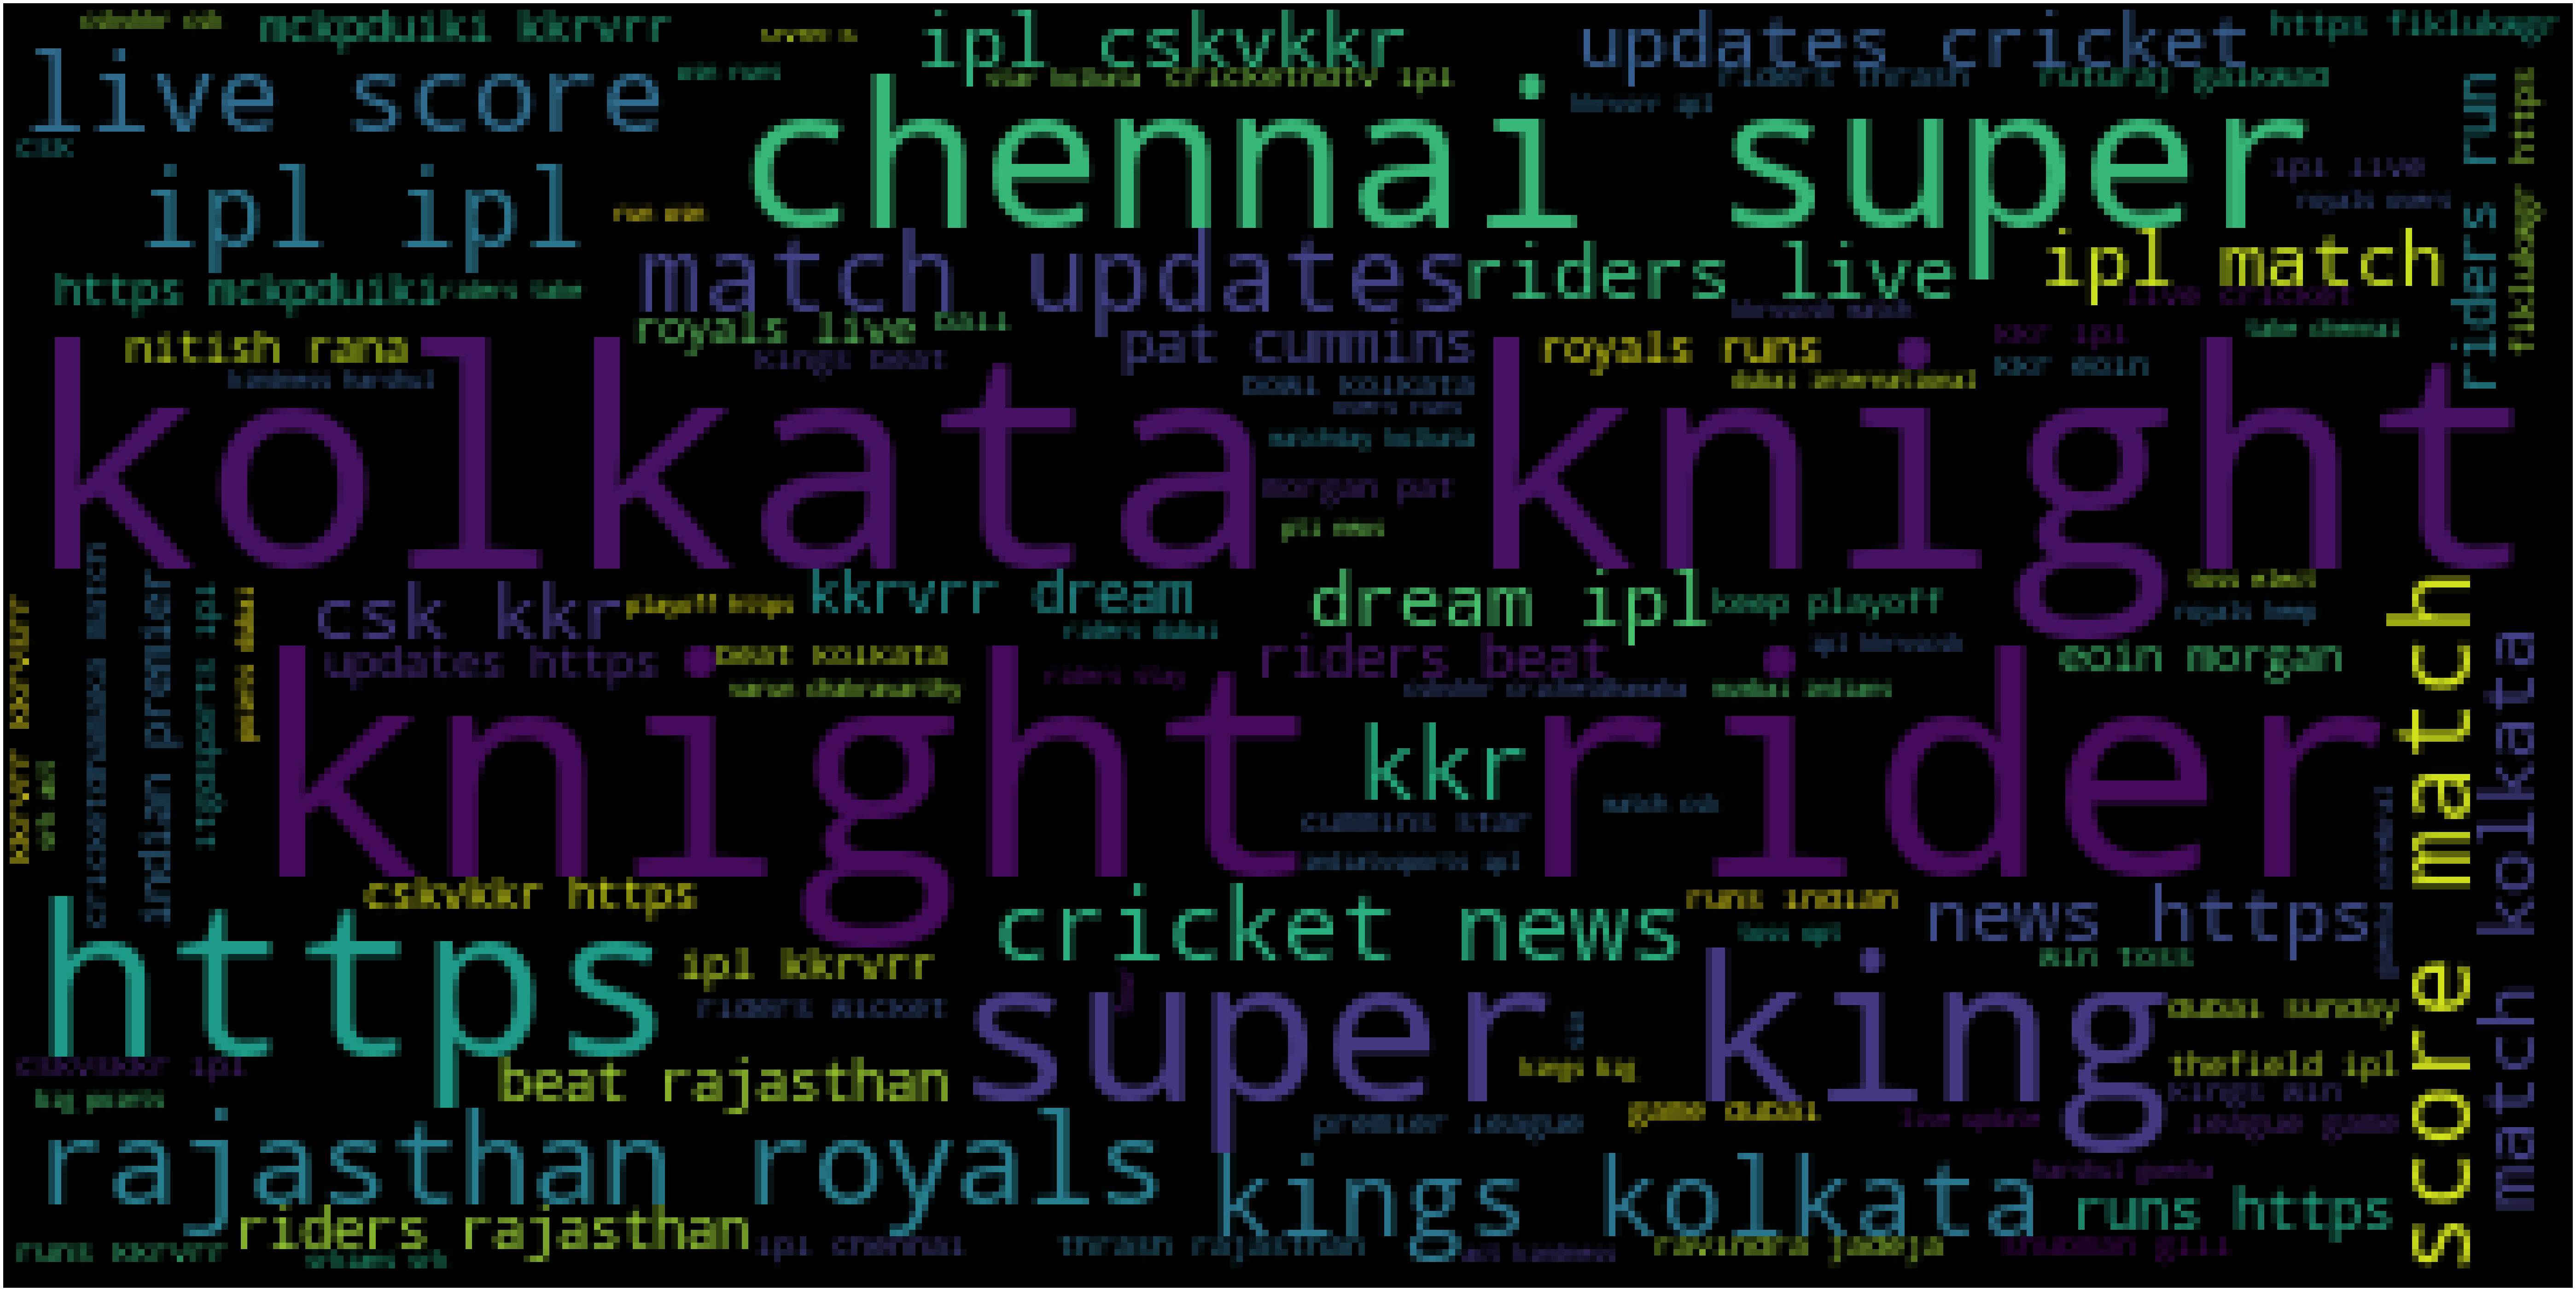

In [19]:
wc(cleaned_data_title,'black','Common Words' )

In [20]:
from textblob import TextBlob

bloblist_desc = list()

twit=dataset1['text'].astype(str)
for row in twit:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    twit_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])
    
def f(twit_polarity_desc):
    if twit_polarity_desc['sentiment'] > 0:
        val = "Positive"
    elif twit_polarity_desc['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

twit_polarity_desc['Sentiment_Type'] = twit_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")

<Figure size 720x720 with 0 Axes>

In [21]:
import collections, numpy as np
a=twit_polarity_desc.Sentiment_Type
neut=np.count_nonzero(a == 'Neutral')
pos=np.count_nonzero(a == 'Positive')
neg=np.count_nonzero(a == 'Negative')
popularity='{0:.2f}'.format((((neut*0.5)+(pos)+(neg*0))/(neut+pos+neg))*100)
popularity

'75.49'